# House Prices: Advanced Regression Techniques  (refactored)

Task: predict the final price of each home in Ames, Iowa, based on 79 variables.

A detailed description of the problem can be found in https://www.kaggle.com/c/house-prices-advanced-regression-techniques .

In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_rows", 101)
pd.set_option("display.max_columns", 100)

In [2]:
import seaborn as sns

from sklearn import utils, base
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet, Ridge
from sklearn.ensemble import RandomForestRegressor

# Data preparation

In [3]:
# change the directory
DATA_DIR = 'housing_prices'
df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'), sep=',').drop_duplicates().drop(["Id"], axis=1)

quality_map_1 = {
    'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1
}

df['ExterQual'] = df['ExterQual'].map(quality_map_1)
df['ExterCond'] = df['ExterCond'].map(quality_map_1)
df['KitchenQual'] = df['KitchenQual'].map(quality_map_1)

df['MSSubClass'] = df['MSSubClass'].astype('category')
df['MoSold']     = df['MoSold'].astype('category')
df['SalePrice']  = df['SalePrice'].astype('float32')

for col in df.columns:
    if df[col].dtype.__str__() == 'object':
        df[col] = df[col].fillna('na').astype('category')

# clean some outliers
df = df.drop( df[ df['LotArea']>100000  ].index.values )
df = df.drop( df[ df['TotalBsmtSF']>5000].index.values )


In [4]:
df_info = pd.DataFrame(index=df.columns)
df_info['nan_counts'] = df.isnull().sum().rename('nan_counts')
df_info['n_unique'] = pd.Series([len(df[col].unique()) for col in df.columns], index=df.columns)
df_info['dtype'] = df.dtypes

# the first 2 have many nan-values (the next 2 are highly correlated with other features)
features_to_drop    = ['LotFrontage', 'GarageYrBlt', 'GarageCars', 'TotRmsAbvGrd'] + ['SalePrice']

categrical_features = df_info.loc[df_info['dtype']=='category'].index.tolist()
categrical_features = list(filter(lambda x: x not in features_to_drop, categrical_features))

continuous_features = df_info.loc[df_info['dtype']!='category'].index.tolist()
continuous_features = list(filter(lambda x: x not in features_to_drop, continuous_features))

df_info.sort_values(by=['nan_counts'], ascending=[False]).head(10)

,nan_counts,n_unique,dtype
LotFrontage,256,110,float64
GarageYrBlt,81,98,float64
MasVnrArea,8,327,float64
MSSubClass,0,15,category
KitchenAbvGr,0,4,int64
GarageType,0,7,category
FireplaceQu,0,6,category
Fireplaces,0,4,int64
Functional,0,7,category
TotRmsAbvGrd,0,12,int64


# Plots

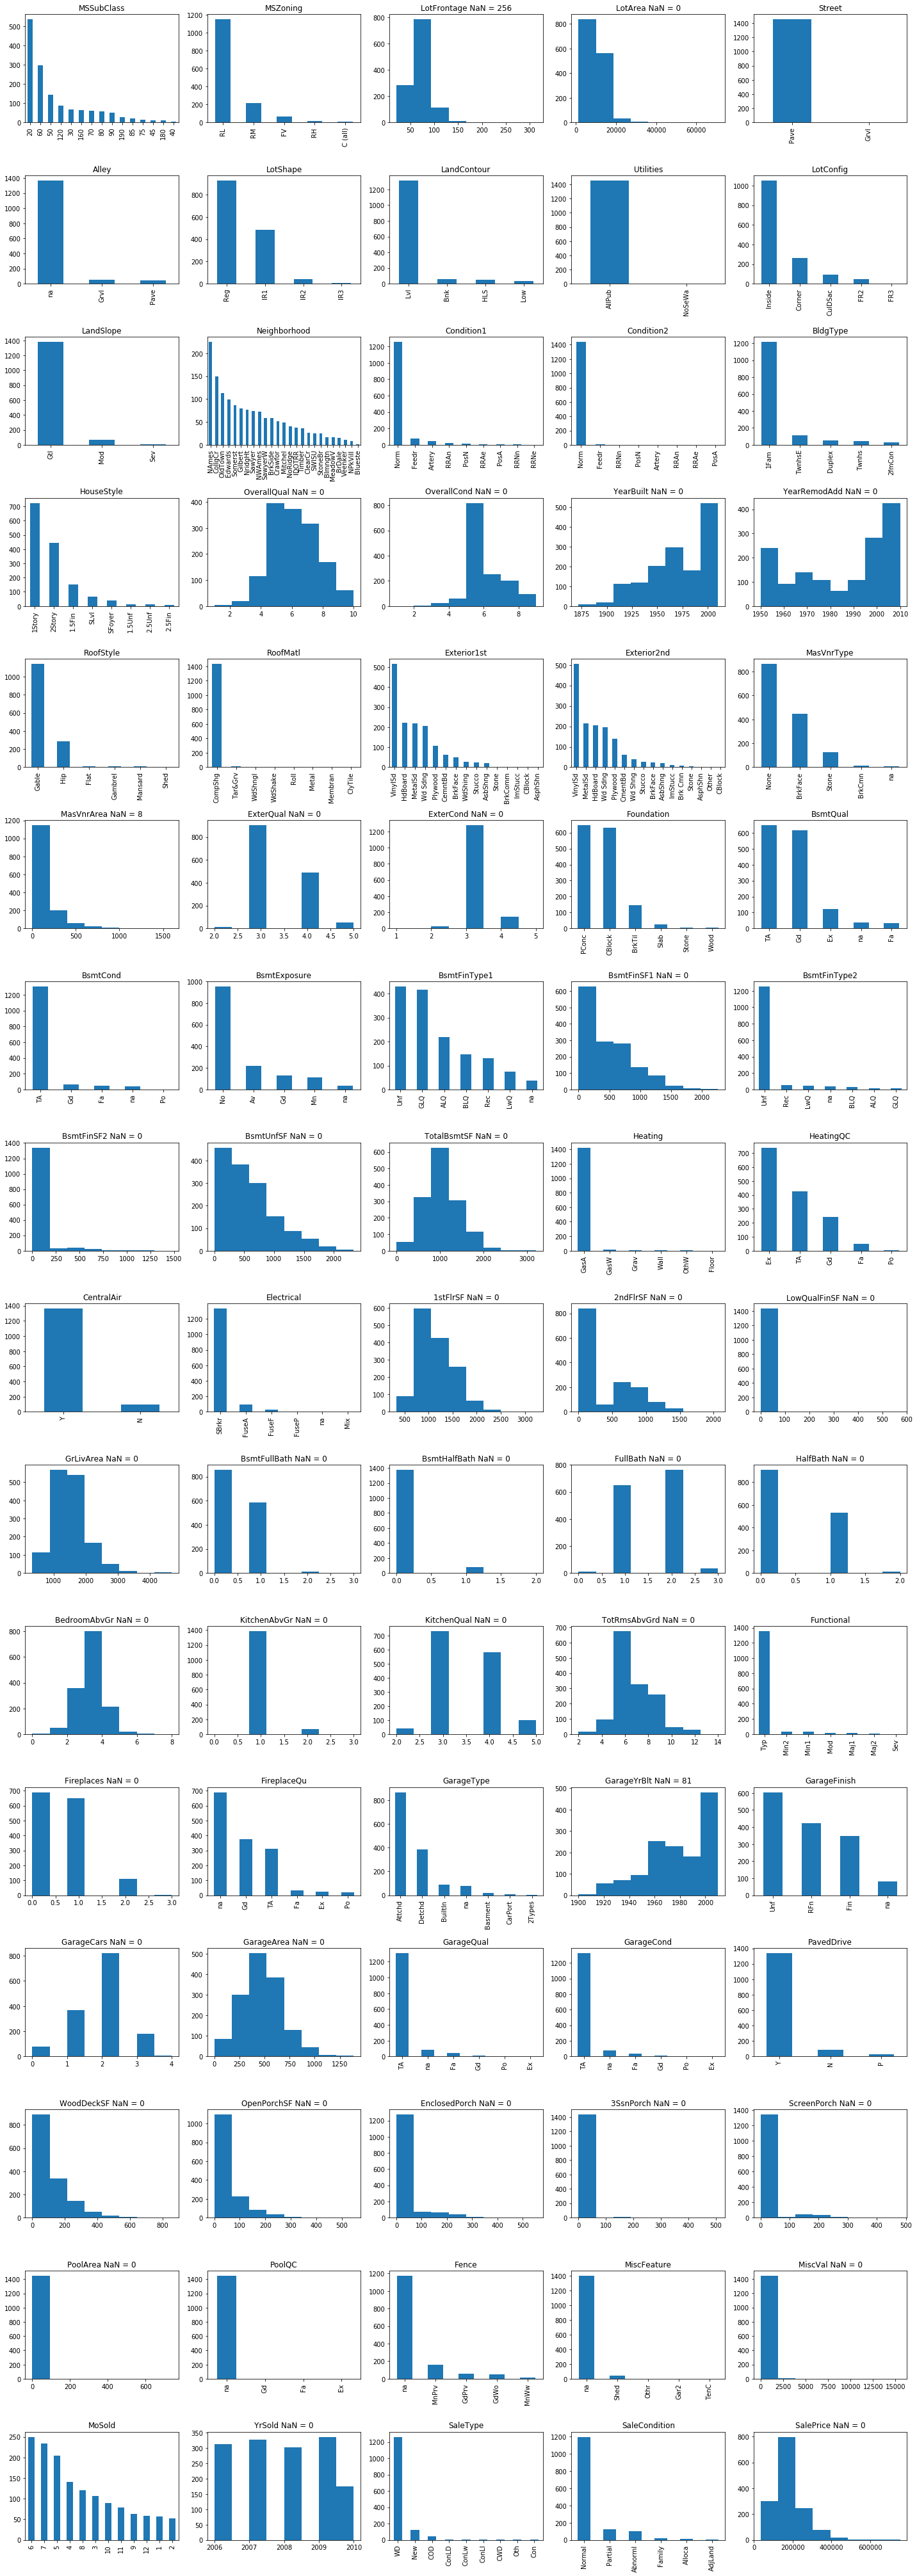

In [5]:
titles = list(df.columns.values)

plt.figure(figsize=(20,7*8))

for idx, col in enumerate(titles):
    
    plt.subplot(16,5,idx+1)

    if "category" == df[col].dtype.__str__():
        df[col].value_counts().plot(kind='bar')
        plt.title(col)
    else:
        plt.hist(df.loc[df[col].notnull(), col], bins=8 )
        plt.title(col + " NaN = " + str(len(df.loc[df[col].isnull(), col])))
    plt.tight_layout()
    
plt.show()

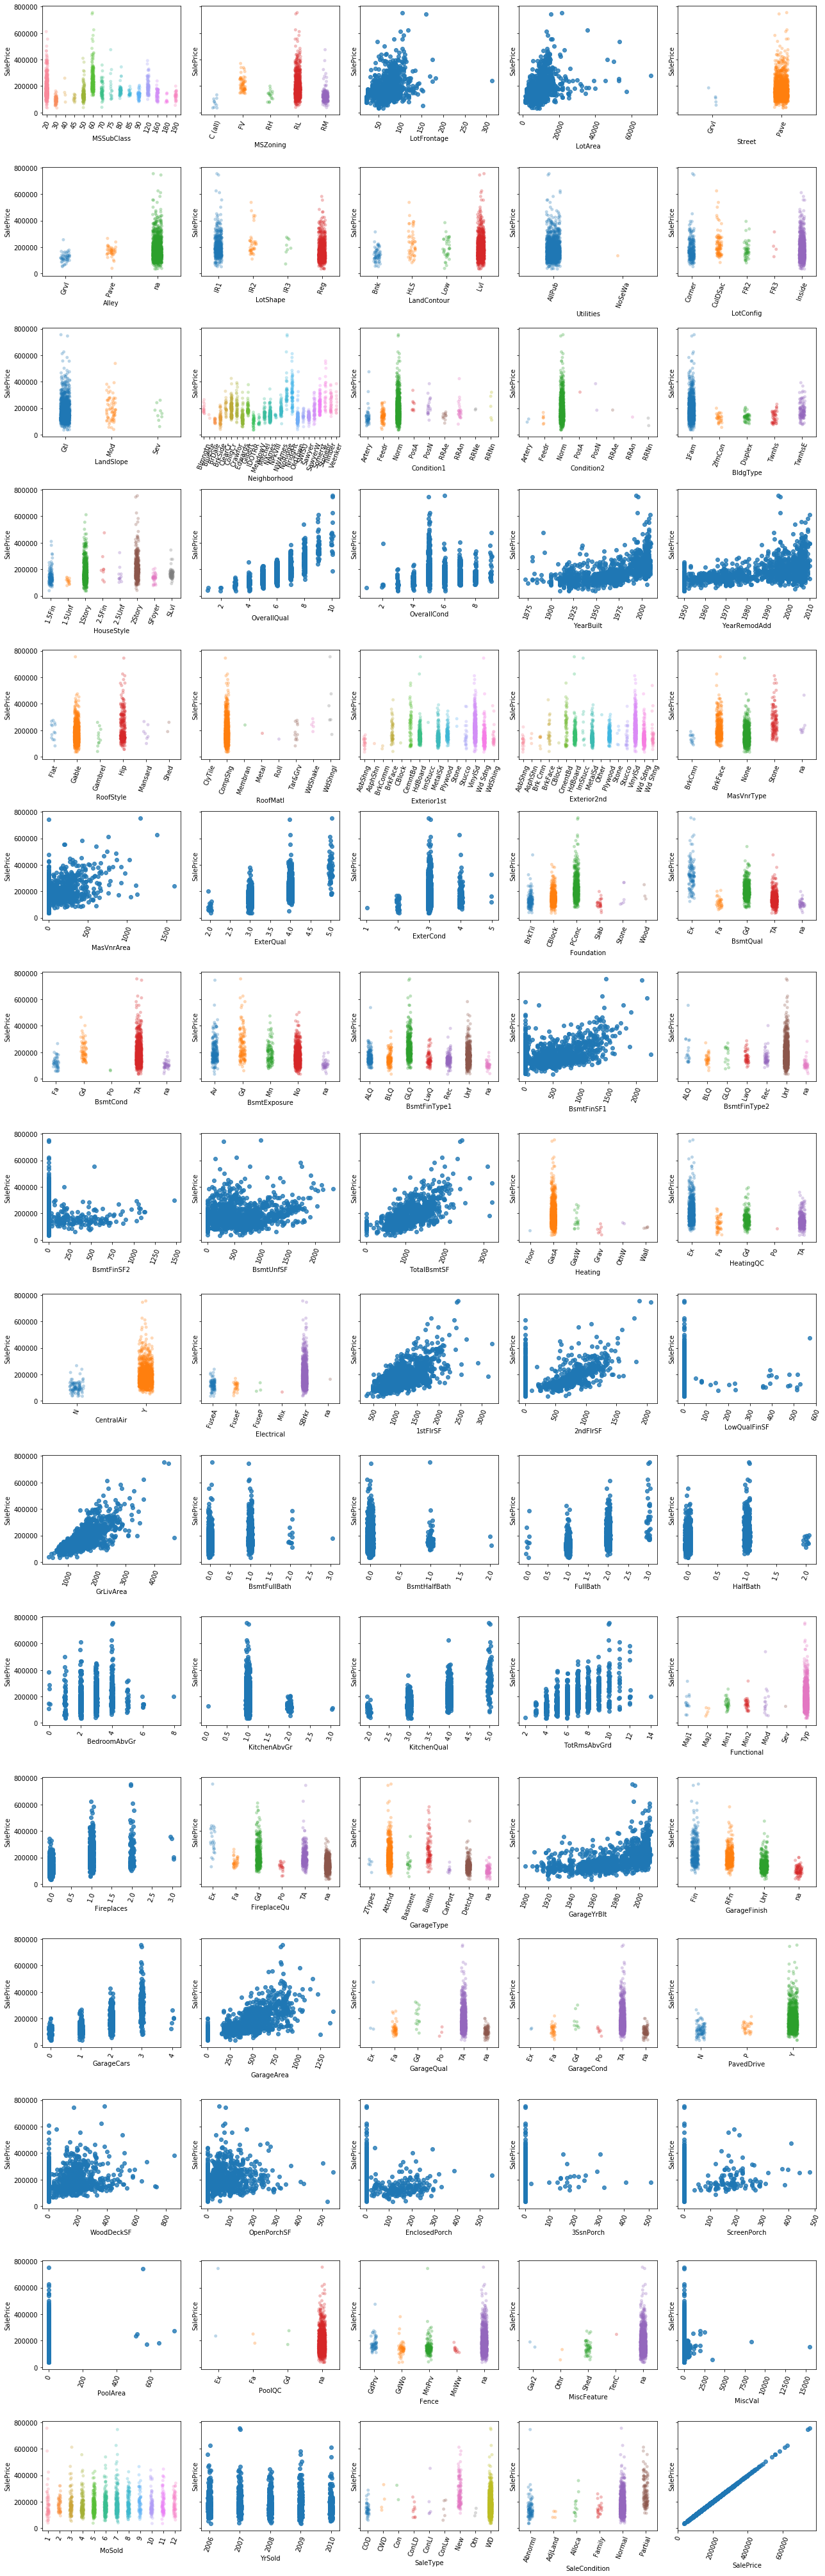

In [6]:
titles = list(df.columns.values)

fig, AX = plt.subplots(16, 5, sharey=True)
fig.set_size_inches(18,8*7)

for idx, col in enumerate(titles):
    
    if "category" == df[col].dtype.__str__():
        g=sns.stripplot(x=str(col), y="SalePrice", data = df,                ax=AX[int(idx/5),idx%5], alpha=0.3);
    else:
        g=sns.regplot(  x=str(col), y="SalePrice", data = df, fit_reg=False, ax=AX[int(idx/5),idx%5], x_jitter=0.05);
        
    plt.setp( AX[int(idx/5),idx%5].xaxis.get_majorticklabels(), rotation=70 )
    plt.tight_layout()
    
plt.show()

From the plots we can see that we can constuct several new features (implemented in the categorical features pipeline)

# Knn with dimensional reduction of the features with type=='category'

In [7]:
X, Y = utils.shuffle(df.drop(['SalePrice'], axis=1), df['SalePrice'], random_state=41)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)

In [8]:
knn_pipeA = Pipeline([
    ('categorical_features', ColumnTransformer(
        [
            ("categrical_features", OneHotEncoder(handle_unknown='ignore'), categrical_features),
            ("LotArea_60000", FunctionTransformer(func=lambda x: 1 * (x > 60000)), ["LotArea"]),
            ("YearBuilt_2000", FunctionTransformer(func=lambda x: 1 * (x > 1999)), ["YearBuilt"]),
            ("2ndFlrSF_missing", FunctionTransformer(func=lambda x: 1 * (x == 0)),
             ["2ndFlrSF", "LowQualFinSF", "EnclosedPorch", "OpenPorchSF", "WoodDeckSF", "3SsnPorch", "ScreenPorch"]),
        ], remainder="drop")
    ),
    ('my_SVD', TruncatedSVD(n_components=40))
])

knn_pipeB = Pipeline([
    ('continuous_features', ColumnTransformer([
            ('identity', 'passthrough', [col for col in continuous_features if col != 'MasVnrArea']),
            ('simple_imputer', SimpleImputer(strategy='constant', fill_value=0), ['MasVnrArea'])
        ], remainder="drop")
    ),
    ('my_StdScaler', StandardScaler())
])

features_generator_knn = FeatureUnion([
        ('my_pipeA', knn_pipeA),
        ('my_pipeB', knn_pipeB)
])


knn_pipe = Pipeline([
    ('features_generator', features_generator_knn),
    ('my_knn_Regressor', TransformedTargetRegressor(
        regressor=KNeighborsRegressor(weights='uniform', p=2, n_jobs=-1),
        transformer=StandardScaler())
    )
])


knn_pipe.set_params(features_generator__my_pipeA__my_SVD__n_components = 40)
knn_pipe.set_params(my_knn_Regressor__regressor__n_neighbors = 3)

parameter_grid = {
    'my_knn_Regressor__regressor__n_neighbors': np.arange(2,51,4), 
    'my_knn_Regressor__regressor__metric': ['minkowski', 'cosine']
}


gs_knn = GridSearchCV(knn_pipe, param_grid=parameter_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
gs_knn.fit(X_train, Y_train)

print('Best score: \t \t', gs_knn.best_score_)
print('Best parameters: \t', gs_knn.best_params_)

Y_train_pred =  gs_knn.best_estimator_.predict(X_train)
Y_test_pred  = gs_knn.best_estimator_.predict(X_test )

print('r2_score_tr = {0:.2f} \t r2_score_te = {1:.2f}'.format(float(r2_score(Y_train,Y_train_pred)), float(r2_score(Y_test,Y_test_pred)) ))

print('DONE')

Best score: 	 	 -1180756339.2
Best parameters: 	 {'my_knn_Regressor__regressor__metric': 'cosine', 'my_knn_Regressor__regressor__n_neighbors': 14}
r2_score_tr = 0.84 	 r2_score_te = 0.77
DONE


In [9]:
knn_best = gs_knn.best_estimator_

# ElNet with dimensional reduction of the features with type=='category'

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)

features_generator_elnet = base.clone(features_generator_knn)

elnet_pipe = Pipeline([
    ('features_generator', features_generator_elnet),
    ('my_ElNet', TransformedTargetRegressor(
        regressor=ElasticNet(random_state=41, selection='random'),
        transformer=StandardScaler())
    )
])

elnet_pipe.set_params(features_generator__my_pipeA__my_SVD__n_components = 160)

parameter_grid = {
    'my_ElNet__regressor__l1_ratio': np.arange(0.01, 0.71, 0.2), 
    'my_ElNet__regressor__alpha': np.logspace(-3, 0, 4)  
}

gs_ElNet = GridSearchCV(elnet_pipe, param_grid=parameter_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
gs_ElNet.fit(X_train, Y_train)

print('Best score: \t \t', gs_ElNet.best_score_)
print('Best parameters: \t', gs_ElNet.best_params_)

Y_train_pred = gs_ElNet.predict(X_train)
Y_test_pred  = gs_ElNet.predict(X_test )

print('r2_score_tr = {0:.2f} \t r2_score_te = {1:.2f}'.format(float(r2_score(Y_train,Y_train_pred)), float(r2_score(Y_test,Y_test_pred)) ))


Best score: 	 	 -627334174.6346829
Best parameters: 	 {'my_ElNet__regressor__alpha': 0.01, 'my_ElNet__regressor__l1_ratio': 0.01}
r2_score_tr = 0.93 	 r2_score_te = 0.77


In [11]:
elnet_best = gs_ElNet.best_estimator_

# Random Forest with dimensional reduction of the features with type=='category'

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)

features_generator_random_forest = base.clone(features_generator_knn)

random_forest_pipe = Pipeline([
    ('features_generator', features_generator_random_forest),
    ('my_RF', TransformedTargetRegressor(
        regressor=RandomForestRegressor(n_estimators=50, min_samples_leaf=1, max_features='auto', bootstrap=True, random_state=41),
        transformer=StandardScaler())
    )
])

random_forest_pipe.set_params(features_generator__my_pipeA__my_SVD__n_components = 160)

parameter_grid = {    
    'my_RF__regressor__max_depth': [5, 10, 15], 
    'my_RF__regressor__min_samples_leaf': [5, 10]
}

gs_RF = GridSearchCV(random_forest_pipe, param_grid=parameter_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
gs_RF.fit(X_train, Y_train)

print('Best score: \t \t', gs_RF.best_score_)
print('Best parameters: \t', gs_RF.best_params_)

Y_train_pred = gs_RF.predict(X_train)
Y_test_pred  = gs_RF.predict(X_test)

print('r2_score_tr = {0:.2f} \t r2_score_te = {1:.2f}'.format(float(r2_score(Y_train,Y_train_pred)), float(r2_score(Y_test,Y_test_pred)) ))


Best score: 	 	 -959022339.8731378
Best parameters: 	 {'my_RF__regressor__max_depth': 10, 'my_RF__regressor__min_samples_leaf': 5}
r2_score_tr = 0.95 	 r2_score_te = 0.76


In [13]:
rf_best = gs_RF.best_estimator_

# Ensemble estimators

We try to find the optimal linear combination between the 3 estimators that we have used separately previously.  
Since `knn_best`, `rf_best`, `elnet_best` are already fitted, we have constructed the EstimatorTransformer.

In [14]:
class EnsembleTransformer(base.BaseEstimator, base.TransformerMixin):    
    
    def __init__(self, estimator1, estimator2, estimator3):
        # the three estimators are already fitted !!!
        self.estimator1 = estimator1
        self.estimator2 = estimator2
        self.estimator3 = estimator3
        
    def fit(self, X, y=None, **kwargs):
        return self

    def transform(self, X):
        all_ests = [self.estimator1, self.estimator2, self.estimator3]
        return np.array([est.predict(X).ravel() for est in all_ests]).T


In [15]:
# Instead of deepcopying the objects GridSearchCV is cloning them which does not allow me to create a single pipeline.
# We have to split the GridSearch task into two parts:
# - Apply the ensemble transformer to the data
# - Use the trasnformed data as input for the GridSearchCV object

ensemble_trf = EnsembleTransformer(estimator1=knn_best, estimator2=rf_best, estimator3=elnet_best)
X_train_trf = ensemble_trf.transform(X_train)
X_test_trf = ensemble_trf.transform(X_test)

lc_pipe = Pipeline([
    ('my_scaler', StandardScaler()),
    ('my_Ridge', TransformedTargetRegressor(
        regressor=Ridge(alpha=0),
        transformer=StandardScaler())
    )
])

parameter_grid = {'my_Ridge__regressor__alpha': np.logspace(-4, -1, 4)}

gs_LC = GridSearchCV(lc_pipe, param_grid=parameter_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
gs_LC.fit(X_train_trf, Y_train)

print('Best score: \t \t', gs_LC.best_score_)
print('Best parameters: \t', gs_LC.best_params_)

Y_train_pred = gs_LC.predict(X_train_trf)
Y_test_pred  = gs_LC.predict(X_test_trf)

print('r2_score_tr = {0:.2f} \t r2_score_te = {1:.2f}'.format(float(r2_score(Y_train,Y_train_pred)), float(r2_score(Y_test,Y_test_pred)) ))


Best score: 	 	 -261684552.6012424
Best parameters: 	 {'my_Ridge__regressor__alpha': 0.1}
r2_score_tr = 0.96 	 r2_score_te = 0.77


In [16]:
# Concatenate the two objcets

gs_LC_complete = Pipeline([
    ('ensemble_transformer', ensemble_trf),
    ('gs_lc', gs_LC.best_estimator_)
])

Y_train_pred = gs_LC_complete.predict(X_train)
Y_test_pred  = gs_LC_complete.predict(X_test)

print('r2_score_tr = {0:.2f} \t r2_score_te = {1:.2f}'.format(float(r2_score(Y_train,Y_train_pred)), float(r2_score(Y_test,Y_test_pred)) ))


r2_score_tr = 0.96 	 r2_score_te = 0.77
